# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [4]:
import numpy as np

# 1 Способ
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент?

**Ответ**:
PCA удаляет линейные зависимости. Это помогает избежать переобучения при генерации RFF-признаков.

PCA уменьшает размерность до new_dim, сохраняя основную информацию, и снижает сложность вычислений.

По заданию гиперпараметр в RFF рассчитывается через медиану расстояний между объектами. В исходном пространстве расстояния могут быть разреженными. После PCA расстояния становятся более адекватными, поэтому проще найти корректное значение гиперпараметра.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [5]:
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator

pipeline = RFFPipeline(n_features=1000, new_dim=50, feature_creator_class=RandomFeatureCreator)

In [6]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

In [5]:
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier_class='LogisticRegression')

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8789

__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [8]:
import time
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

In [6]:
# Выбор подмножества для ускорения
ind = np.random.choice(np.arange(x_train.shape[0]), size=5000, replace=False)
x_train_subset, y_train_subset = x_train[ind], y_train[ind]


**Линейный SVM на исходных признаках**

In [ ]:
start_time = time.time()
model_svm_linear = LinearSVC()
model_svm_linear.fit(x_train_subset, y_train_subset)
y_pred_svm_linear = model_svm_linear.predict(x_test)
svm_linear_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**RBF Kernel SVM на исходных признаках**

In [ ]:
start_time = time.time()
model_svm_rbf = SVC(kernel="rbf")
model_svm_rbf.fit(x_train_subset, y_train_subset)
y_pred_svm_rbf = model_svm_rbf.predict(x_test)
svm_rbf_time = time.time() - start_time

**LogReg на случайные признаки**

In [ ]:
start_time = time.time()
model_logreg_rff = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier_class='LogisticRegression')
model_logreg_rff.fit(x_train, y_train)
y_pred_logreg_rff = model_logreg_rff.predict(x_test)
logreg_rff_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**SVM на случайные признаки**

In [ ]:
start_time = time.time()
model_svm_rff = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier_class='SVM')
model_svm_rff.fit(x_train, y_train)
y_pred_svm_rff = model_svm_rff.predict(x_test)
svm_rff_time = time.time() - start_time

**PCA + CatBoost**

In [13]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 47.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

In [ ]:
start_time = time.time()

pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(x_train)
test_features_pca = pca.transform(x_test)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(train_features_pca, y_train, train_size=0.8, random_state=42)

params = {
    "iterations": 100,
    "learning_rate": 0.1,
    "verbose": 0
}

classifier_catboost = CatBoostClassifier(**params)
classifier_catboost.fit(X_train_pca, y_train_pca)
y_pred_catboost = classifier_catboost.predict(test_features_pca)

catboost_time = time.time() - start_time

In [ ]:
# Оценка качества
results = {
    "LogReg RFF": {
        "accuracy": accuracy_score(y_test, y_pred_logreg_rff),
        "time": logreg_rff_time
    },
    "SVM RFF": {
        "accuracy": accuracy_score(y_test, y_pred_svm_rff),
        "time": svm_rff_time
    },
    "Linear SVM": {
        "accuracy": accuracy_score(y_test, y_pred_svm_linear),
        "time": svm_linear_time
    },
    "RBF Kernel SVM": {
        "accuracy": accuracy_score(y_test, y_pred_svm_rbf),
        "time": svm_rbf_time
    },
    "PCA + CatBoost": {
        "accuracy": accuracy_score(y_test, y_pred_catboost),
        "time": catboost_time
    },
}
results

{'LogReg RFF': {'accuracy': 0.8785, 'time': 582.1315140724182},
 'SVM RFF': {'accuracy': 0.8806, 'time': 663.5659618377686},
 'Linear SVM': {'accuracy': 0.7276, 'time': 86.7362871170044},
 'RBF Kernel SVM': {'accuracy': 0.836, 'time': 26.586111068725586},
 'PCA + CatBoost': {'accuracy': 0.8295, 'time': 58.56579375267029}}

Выводы:

1.   Лучшее качество из SVM показал SVM RFF, но по времени работал значительно дольше остальных
2.   Качество ядрового SVM сравнимо с SVM RFF, но по времени ядровой SVM отработал сильно быстрее
3.   Самое худшее качество оказалось на Linear SVM
3.   Качество бустинга оказалось почти такое же, как у ядрового SVM, хотя работал он медленнее


Подытоживая, можно сказать, что rff и правда позволяет улучшить качество, и можно его использовать если нет жесткого ограничения по времени

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA?
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

**Помогает ли предварительное понижение размерности с помощью PCA?**

In [ ]:
new_dims = [20, 50, 100, 200, 350, 500]
accuracy_pca = {}

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
model_no_pca = RFFPipeline(n_features=1000, use_PCA=False, classifier_class='LogisticRegression')
model_no_pca.fit(x_train_scaled, y_train)
y_pred_no_pca = model_no_pca.predict(x_test_scaled)
accuracy_pca['Без PCA'] = accuracy_score(y_test, y_pred_no_pca)
accuracy_pca['Без PCA']

0.8631

In [ ]:
for dim in new_dims:
    model_pca = RFFPipeline(n_features=1000, new_dim=dim, use_PCA=True, classifier_class='LogisticRegression')
    model_pca.fit(x_train, y_train)
    y_pred_pca = model_pca.predict(x_test)
    accuracy_pca[dim] = accuracy_score(y_test, y_pred_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

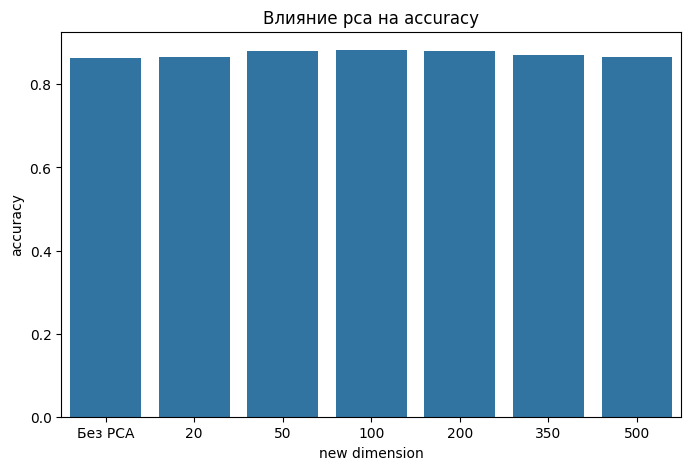

In [ ]:
x_labels = ["Без PCA"] + new_dims

y_values = [accuracy_pca["Без PCA"]] + [accuracy_pca[dim] for dim in new_dims]

plt.figure(figsize=(8, 5))
sns.barplot(x=x_labels, y=y_values)

plt.xlabel("new dimension")
plt.ylabel("accuracy")
plt.title("Влияние pca на accuracy")

plt.show()

Видим, что действительно без PCA accuracy немного ниже. Пик достигается примерно при dim равном 100 и дальше accuracy начинает снижаться, значит dim где-то от 50 до 100 оптимален.

**Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?**

In [10]:
# Выбор подмножества для ускорения
ind = np.random.choice(np.arange(x_train.shape[0]), size=5000, replace=False)
x_train_subset, y_train_subset = x_train[ind], y_train[ind]

In [12]:
n_features_values = list(range(100, 5000, 500))
accuracy_features = {}

In [13]:
for n_feat in n_features_values:
    model_n_feat = RFFPipeline(n_features=n_feat, new_dim=50, use_PCA=True, classifier_class='LogisticRegression')
    model_n_feat.fit(x_train_subset, y_train_subset)
    y_pred_n_feat = model_n_feat.predict(x_test)
    accuracy_features[n_feat] = accuracy_score(y_test, y_pred_n_feat)
    accuracy_features[n_feat]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

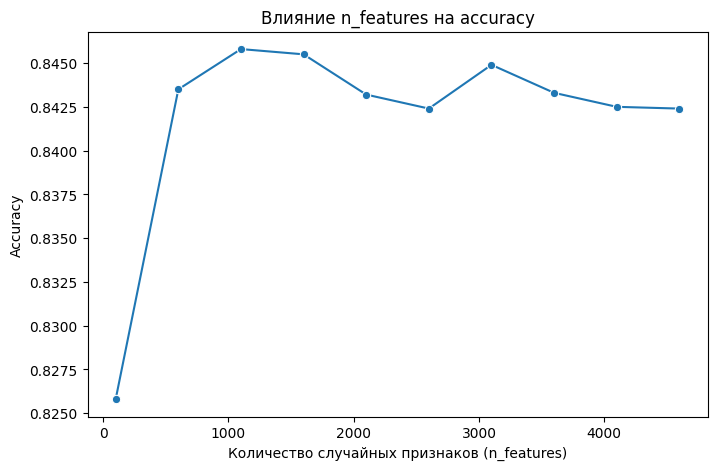

In [14]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=list(accuracy_features.keys()), y=list(accuracy_features.values()), marker='o')
plt.xlabel('Количество случайных признаков (n_features)')
plt.ylabel('Accuracy')
plt.title('Влияние n_features на accuracy')
plt.show()

Видим, что увеличение числа признаков не сильно влияет на качество (после значения 500 признаков accuracy остается примерно стабильным). Оптимальное количество равно примерно 1500

**Важно ли, какую модель обучать — логистическую регрессию или SVM?**

Такой эксперимент мы провели во 2 задании. SVM обучается чуть дольше, чем LogReg, но качество у LogReg чуть ниже, хотя у обеих моделей оно достаточно высокое. Поэтому, если цель - получить максимальное качество и можем чуть дольше подождать, то используем svm.

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.


In [16]:
from homework_practice_08_rff import RFFPipeline, OrthogonalRandomFeatureCreator


start_time = time.time()
model_svm_orf = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, feature_creator_class=OrthogonalRandomFeatureCreator, classifier_class='SVM')
model_svm_orf.fit(x_train, y_train)
y_pred_svm_orf = model_svm_orf.predict(x_test)
svm_orf_time = time.time() - start_time
svm_orf_accuracy = accuracy_score(y_test, y_pred_svm_orf)


In [17]:
start_time = time.time()
model_logreg_orf = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, feature_creator_class=OrthogonalRandomFeatureCreator, classifier_class='LogisticRegression')
model_logreg_orf.fit(x_train, y_train)
y_pred_logreg_orf = model_logreg_orf.predict(x_test)
logreg_orf_time = time.time() - start_time
logreg_orf_accuracy = accuracy_score(y_test, y_pred_logreg_orf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
{
    "SVM ORF": {
        "accuracy": svm_orf_accuracy,
        "time": svm_orf_time
    },
    "LogReg ORF": {
        "accuracy": logreg_orf_accuracy,
        "time": logreg_orf_time
    }
}

{'SVM ORF': {'accuracy': 0.8828, 'time': 542.7587792873383},
 'LogReg ORF': {'accuracy': 0.8756, 'time': 182.68062615394592}}

По качеству примерно то же самое, по времени получается немного быстрее 

__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
# Пример

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**.
Подумайте о том, как в формулах правильно учесть свободный коэффициент.

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь:
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание:
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___
$$
\nabla ...
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [ ]:
from homework_practice_08_kernel_regression import KernelRidgeRegression